In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.stats import binned_statistic_2d

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
def create_dic(dic):
    
    tt = np.array(dic['tmin'])
    mask = np.where(tt<=-50)
    
    pp = np.array(dic['pmax'])[mask]
    sh = np.array(dic['shear'])[mask] #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])[mask]
    umax = np.array(dic['u925'])[mask]
    qq = np.array(dic['q925'])[mask]
    qup = np.array(dic['q650'])[mask]
    tup = np.array(dic['t650'])[mask]
    tlow = np.array(dic['t925'])[mask]
    tt = np.array(dic['tmin'])[mask]
    ttm = np.array(dic['tmean'])[mask]
    month = np.array(dic['month'])[mask]
    area = np.array(dic['area'])[mask]
    lat = np.array(dic['clat'])[mask]
    lon = np.array(dic['clon'])[mask]
    tcwv = np.array(dic['tcwv'])[mask]
    tgrad = np.array(dic['tgrad'])[mask]
    tbox = np.array(dic['tbox'])[mask]
    rh = np.array(dic['rh925'])[mask]
    pall = np.array(dic['p'])[mask]
    year = np.array(dic['year'])[mask]
    
    
    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    #thetae_up = u_met.theta_e(650, tup-273.15, qup)


    thetae_down_man = u_met.theta_e(925, tlow-273.15, qq)

    p = units.Quantity(925, 'hPa')
    t = units.Quantity(tlow, 'K')
    q = units.Quantity(qq, 'kg/kg')
    thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))-273.15
   
    thetae = thetae_down - thetaes_up
    thetaes = thetaes_down - thetaes_up
    
#     qdef = u_met.qdeficit(qq, tup, 650)
    
    #ipdb.set_trace()
    
    if tgrad.ndim == 2:
        tgrad = tlow
    if tbox.ndim == 2:
        tbox = tlow   ############## this is just to deal with tbox error

    obs_pcp = {
        'prcp' : pp+3,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        #'t650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month, 
        'year' : year,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'rh' : rh,
        #'tmean' : ttm,
        #'theta' : theta,
        'theta_e' : thetae,
        'theta_es' : thetaes,
        #'thup' : thetae_up,
        #'thdown' : thetae_down,
        'tcwv' : tcwv,
        'tgrad' : tgrad.squeeze(),
        'tbox' : tbox.squeeze(),
        'lat' : lat,
        'lon' : lon,
      #  'pall' : pall
    } 
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [4]:
def create_dic_model(dic):
    
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['umin_mid'])
    umax = np.array(dic['umax_srfc'])
    qq = np.array(dic['qmax']) #+ 0.5
    tup = np.array(dic['tmidmax'])
    tcwv = np.array(dic['tcwv'])
    tgrad = np.array(dic['tgrad'])
    tbox = np.array(dic['tdiff'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    year = np.array(dic['year'])
    tsrfc = np.array(dic['tsrfcmax']) #+ 3
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    pall = np.array(dic['p'])

    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup+273.15, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    
#     thetaes_up = []
#     ipdb.set_trace()
#     for tl in t:
#         try:
#             thetaa = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
#             thetaes_up.append(thetaa)
#             ipdb.set_trace()
#         except:
#             thetaes_up.append(np.nan)

    thetaes_up = np.array(thetaes_up)

    p = units.Quantity(925, 'hPa')
    t = units.Quantity(tsrfc+273.15, 'K')
    q = units.Quantity(qq/1000, 'kg/kg')
    thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))
    
#     thetaes_down = []

#     for tl in t:
#         try:
#             thetaee = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
            
#             thetaes_down.append(thetaee)    
#         except:
#             thetaes_down.append(np.nan) 

#     thetaes_down = np.array(thetaes_down)  
    
    thetaes = thetaes_down-thetaes_up  
    thetae = thetae_down -thetaes_up  
#     qdef = u_met.qdeficit(qq/1000, tup+273.15, 650)
    
    try:
        thetamax = np.array(dic['thetamax'])
        thetamean = np.array(dic['thetamean'])   
    except:
        pass

    obs_pcp = {
        'prcp' : pp+2,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq,
        't925' : tsrfc,
        'tcwv' : tcwv,
        'tgrad' : tgrad,
        'tbox' : tbox,
        'shear' : sh*-1,
        'month' : month,
        'year' : year,
        'area' : (area)*(4.4**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
        'theta_es' : thetaes,
     #   'pall' : pall
    } 

#     try:
    obs_pcp['theta_e']=thetae #+4
#         #obs_pcp['thetamean']=thetamean
#     except:
#         pass
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [5]:
ttag = 'hourly'
if ttag=='hourly':
    rres = 'means'
else:
    rres = '0.7deg'
cp4_histf = ('modelhist', cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_hist_*.p')
cp4_futf = ('modelfut' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_fut_*.p')
gpmf = ('obs' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_'+ttag+'_*.p')
dlist = [cp4_histf,cp4_futf,gpmf]

In [6]:
for d in dlist:
    
    #ipdb.set_trace()
    ds = glob.glob(d[1])
    
    
    
    for ids, dss in enumerate(ds):
        data = pkl.load( open (dss, 'rb'))
        #data.update(dat)
        
        if 'model' in d[0]:
            if d[0] == 'modelhist':
                cp4_h = create_dic_model(data)
                if ids > 0:
                    histf = pd.concat([histf, cp4_h])
                else:
                    histf = cp4_h    
            else:
                cp4_f = create_dic_model(data)
                if ids > 0:
                    futf = pd.concat([futf, cp4_f])
                else:
                    futf = cp4_f
        if 'obs' in d[0]:
            if d[0] == 'obsm':
                obs_gpmc_m = create_dic(data)
                if ids > 0:
                    obs_gpmc = pd.concat([obs_gpmc, obs_gpmc_m])
                else:
                    obs_gpmc = obs_gpmc_m
            else:
                obs_gpmf_h = create_dic(data)
                if ids > 0:
                    obs_gpmf = pd.concat([obs_gpmf, obs_gpmf_h])
                else:
                    obs_gpmf = obs_gpmf_h
                    

        del data

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [7]:
obs_gpmf.head()

,prcp,q925,q650,t925,shear,month,year,area,tmin,rh,theta_e,theta_es,tcwv,tgrad,tbox,lat,lon
0,36.945941,16.032429,5.258263,21.451288,21.597702,9,2008,6350,-80.861286,92.476395,5.352094,9.537061,50.086918,0.174528,3.371307,15.337195,-11.309676
1,7.216382,13.945688,6.594621,21.226892,-3.408928,8,2008,9500,-66.841842,80.737831,0.152769,10.020525,47.465511,0.115285,0.348175,11.320022,-12.558099
2,62.185143,14.722182,4.939521,24.223535,20.380962,7,2008,109950,-84.518429,71.706879,4.475381,23.200466,46.883617,0.169490,4.454224,15.367470,-12.196891
3,5.248306,17.130347,6.434912,21.410577,18.177017,8,2008,19025,-69.398859,99.019821,13.786762,14.390733,59.113689,0.239586,0.140045,17.328758,-12.240657
4,46.297786,16.088208,5.281735,27.334863,20.113298,6,2008,190925,-88.485493,65.269966,13.391944,42.317307,48.521294,0.178521,4.899445,11.785741,6.625053


In [8]:
np.percentile(histf['tcwv'],0.5)  # 99.5 percentile

25.460361663990852

In [9]:
print(np.max(obs_gpmf.lat))
print(np.min(obs_gpmf.lat))
print(np.max(obs_gpmf.lon))
print(np.min(obs_gpmf.lon))

17.824957782145926
9.000161827841007
12.107882421128927
-14.998084590200353


In [10]:
tag = 'Sahel'
domainSA = [-10,12,5,8.5]
domainSS = [-10,15,9,18]  # 8.5, 17.5
domainWA = [-10,12,5,17.5]
domainOuaga = [-4.5,2,11,13.5]  
nb = 23
if ttag == 'hourly':
    region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(3,24,nb), np.linspace(-10,10,nb), np.linspace(29,55,nb)], #TCW np.linspace(25,57,nb) #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
              'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(0,27,nb), np.linspace(-10,10,nb), np.linspace(25,57,nb)],
              'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
              'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
             }
else:
    region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(7,18,nb), np.linspace(-10,10,nb), np.linspace(28,51,nb)], # 28,51 #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
          'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(0,27,nb), np.linspace(-10,10,nb), np.linspace(25,57,nb)],
          'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
          'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
         }


domain = region[tag][0]
tname = region[tag][1]


m1 = 5#3
m2 =10#11
obs_gpm = obs_gpmf[(obs_gpmf.lon>=domain[0])&(obs_gpmf.lon<=domain[1])&(obs_gpmf.lat>=domain[2])&(obs_gpmf.lat<=domain[3])& (obs_gpmf.month>=m1) & (obs_gpmf.month<=m2)] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
hist = histf[(histf.lon>=domain[0])&(histf.lon<=domain[1])&(histf.lat>=domain[2])&(histf.lat<=domain[3])& (histf.month>=m1) & (histf.month<=m2)]# & (histf.tbox<=10)]
fut = futf[(futf.lon>=domain[0])&(futf.lon<=domain[1])&(futf.lat>=domain[2])&(futf.lat<=domain[3])& (futf.month>=m1) & (futf.month<=m2)]# & (futf.tbox<=10)]


In [11]:
print('hist', hist.lat.min(), hist.lat.max(), hist.lon.min(), hist.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

hist 9.008251190185547 17.99925422668457 -9.980758666992188 14.764739990234375
OBS_gpm 9.000807314938331 17.72173831393142 -9.99853562356402 12.107882421128927


In [12]:
len(obs_gpm)

26739

In [117]:
np.mean(hist.prcp)

20.608027012717006

In [120]:
np.percentile(hist.prcp,95)

42.53122729318467

In [121]:
hist

,prcp,q925,t925,tcwv,tgrad,tbox,shear,month,year,area,tmin,tmean,lat,lon,theta_es,theta_e
2063,18.867353,14.926735,30.77,44.697625,0.036556,6.077653,13.420918,5,2002,29175.52,-72.779764,-60.688728,10.000502,0.164490,64.183153,11.339871
2064,2.479877,14.048980,31.07,38.422002,15.048322,6.614840,10.216837,5,2002,6911.52,-61.534917,-56.490522,9.838503,6.118011,65.288977,7.668456
2065,36.363364,15.080625,26.64,43.785130,0.030805,5.172921,12.437500,5,2002,6485.60,-75.454839,-63.829143,9.818253,-4.877747,37.386550,8.808020
2066,18.438323,14.847708,31.80,40.363849,0.028982,5.200653,13.710938,5,2002,40694.72,-73.664793,-57.950566,11.316753,-5.201752,73.114977,12.885053
2067,29.069875,12.460645,29.54,40.726211,0.024351,6.140851,11.705645,5,2002,6834.08,-67.939869,-56.871737,10.567503,-2.994492,55.866536,3.198807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12537,20.031130,15.911020,26.79,33.571482,0.021367,3.602180,8.948980,10,2001,9408.96,-69.234883,-58.872885,10.122002,-3.176743,40.272283,13.559211
12545,17.729391,15.306512,25.47,36.246893,0.033776,4.108549,9.284884,10,2001,7569.76,-71.438990,-57.565033,9.372751,-9.595993,32.624899,10.298827
12546,22.605551,14.849783,26.73,34.976947,0.029167,4.642127,8.730978,10,2001,7085.76,-66.915023,-57.644175,9.474003,-5.667496,43.135924,13.389121
12548,9.560349,15.431837,26.48,32.963322,0.021343,3.600512,8.367347,10,2001,8111.84,-64.629853,-56.297755,10.182753,-3.217255,38.886972,12.195572


In [135]:
np.mean(hist.groupby('year').min().prcp)

2.0000000000153073

In [140]:
np.mean(hist.groupby('year').quantile(0.10).prcp)

5.058543852578376

In [130]:
np.mean(hist.groupby('year').max().tcwv)

78.85028133520035

In [142]:
np.mean(hist.groupby('year').quantile(0.10).tcwv)

36.08888830538447

In [133]:
np.mean(hist.groupby('year').quantile(0.99).prcp)/np.mean(hist.groupby('year').quantile(0.99).tcwv)

0.9700960709560237

In [134]:
np.mean(hist.groupby('year').max().prcp)/np.mean(hist.groupby('year').max().tcwv)

0.9346691805056042

Text(0.5, 1.0, '-0.57')

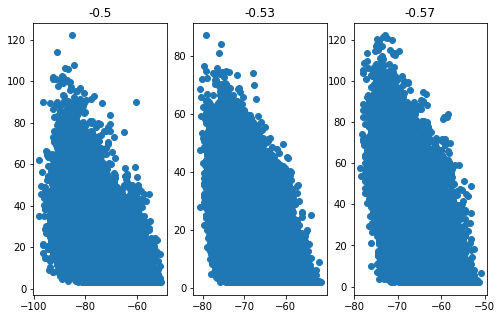

In [14]:

cp4s = [obs_gpm.tmin, obs_gpm.prcp] # gpm
cp25s = [hist.tmin, hist.prcp] #cp4
futur = [fut.tmin, fut.prcp] 


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))





Text(0.5, 1.0, '-0.49')

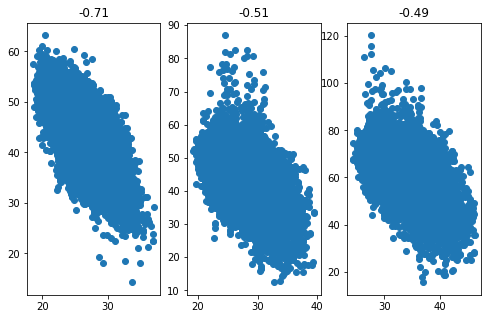

In [15]:

cp4s = [obs_gpm.t925, obs_gpm.tcwv] # gpm
cp25s = [hist.t925, hist.tcwv] #cp4
futur = [fut.t925, fut.tcwv] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

Text(0.5, 1.0, '0.01')

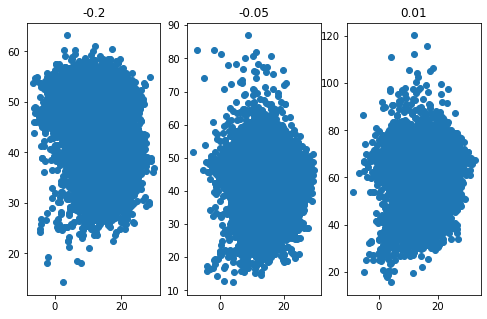

In [16]:

cp4s = [obs_gpm.shear, obs_gpm.tcwv] # gpm
cp25s = [hist.shear, hist.tcwv] #cp4
futur = [fut.shear, fut.tcwv] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

In [57]:
oposi = (obs_gpm.q925>=8.) & (obs_gpm.shear>0) &  (obs_gpm.prcp>=8) & (obs_gpm.theta_e>=-40) & (obs_gpm.area>=5000) & (obs_gpm.tmin<=-55) # & ((obs_gpm.month>=9) | (obs_gpm.month<=5))
cposi = (hist.q925>=8.) & (hist.shear>0) &  (hist.prcp>=8) & (np.isfinite(hist.q925)) & np.isfinite(hist.shear)  & (hist.area>=5000) & (hist.tmin<=-55)
fposi = (fut.q925>=8.) & (fut.shear>0) &  (fut.prcp>=8) & (np.isfinite(fut.q925)) & np.isfinite(fut.shear)  & (fut.area>=5000) & (fut.tmin<=-55)

In [58]:
obs = obs_gpm[oposi]
cp4 = hist[cposi]
cp4f = fut[fposi]
cp4.area = cp4.area.values

/home/ck/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [59]:
obs.keys()

Index(['prcp', 'q925', 'q650', 't925', 'shear', 'month', 'year', 'area',
       'tmin', 'rh', 'theta_e', 'theta_es', 'tcwv', 'tgrad', 'tbox', 'lat',
       'lon'],
      dtype='object')

In [143]:
np.percentile(obs.tcwv,99)

54.74402046203613

In [149]:
np.mean(obs.groupby('year').max().prcp)

98.40170145006165

In [151]:
np.mean(obs.groupby('year').max().tcwv)

58.647104263305664

In [153]:
np.mean(obs.groupby('year').max().prcp)/np.mean(obs.groupby('year').max().tcwv)

1.6778612121797403

In [156]:
np.percentile(obs.prcp[(obs.tcwv>=29) & (obs.tcwv<=32)], 95)

39.89508679735714

In [61]:
cp4.area.min()

5014.240000000001

In [62]:
obs.area.min()

5225

In [63]:
len(obs)

22576

In [64]:
len(cp4)

48023

In [65]:
len(cp4f)

37805

In [66]:
len(np.unique(obs_gpm.year))

12

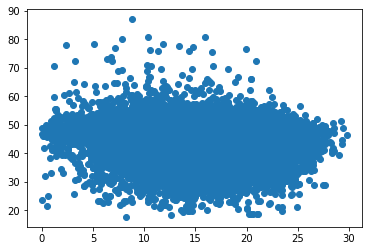

In [67]:
plt.scatter(cp4.shear, cp4.tcwv)

In [68]:
def gauss(data, sigma):
    sigma=sigma                  # standard deviation for Gaussian kernel
    truncate=4.0               # truncate filter at this many sigmas

    U=data       # random array...

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

In [157]:
# sbin = np.linspace(0,26.8,25)
# tbin = np.linspace(27,57,25)

sbin = np.linspace(0,26,25) #28
#tbin = np.linspace(27,57,28)

years_needed = 5

q1 = 1 #0.8
q2 = 99 #99.5
#sbin = np.linspace(np.percentile(obs.shear,q1) ,np.max([np.percentile(obs.shear,q2),np.percentile(cp4.shear,q2)]),25) #np.min([np.percentile(obs.shear,q1),np.percentile(cp4.shear,q1)])
tbin = np.linspace(np.min([np.percentile(obs.tcwv,q1),np.percentile(cp4.tcwv,q1)]) ,np.max([np.percentile(obs.tcwv,q2),np.percentile(cp4.tcwv,q2)]),25)

testbins = [sbin,tbin]
vlist=['prcp']


obs_tcwv = hist2d.create_2dhist_maxYear(obs.shear, obs.tcwv, sbin, tbin, obs, vlist, valmin=years_needed)
cp4_tcwv = hist2d.create_2dhist_maxYear(cp4.shear, cp4.tcwv, sbin, tbin, cp4, vlist, valmin=years_needed)

In [158]:
obs_tcwv.keys()

dict_keys(['prcp', 'prcp_val', 'prcp_std', 'xbins', 'ybins'])

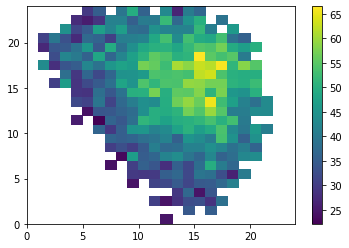

In [108]:
plt.pcolormesh(obs_tcwv['prcp'])
plt.colorbar()

In [109]:
def run_small(data, count, bins, axis=0):
    
    dd = data    
    
    mean = np.nanmean(dd,axis=axis)
    val = np.nansum(np.isfinite(dd),axis=axis)
    
    perc = np.nanpercentile(dd, [10,90], axis=axis)

    sbin = bins[axis]
    bins = np.round(sbin[0:-1]+((sbin[1::]-sbin[0:-1])/2),2)
    
    def weighted_regress(bins,data, pval):
        import statsmodels.api as sm
        data = np.array(data)
        pos = np.isfinite(data)
        inbins = bins#[pos]
        indata = data#[pos]
        inval = np.array(pval)#[pos]
        X = sm.add_constant(inbins)
        weight = inval / np.sum(inval)
        #ipdb.set_trace()
        return sm.WLS(indata,X, missing='drop', weights=weight).fit() # #, weights=weight
    
    sbin = testbins[axis]
    bins = np.round(sbin[0:-1]+((sbin[1::]-sbin[0:-1])/2),2)
    fillmean = mean.copy()
    fillmean[np.isnan(fillmean)]=0

    val[np.isnan(fillmean)]=0
    maxpos = np.argmax(fillmean)
    wls_model = weighted_regress(bins[0:maxpos+1], fillmean[0:maxpos+1], val[0:maxpos+1])

    intercept = wls_model.params[0] #  intercept
    slope = wls_model.params[1] #  slope
    r_value = wls_model.rsquared  #rsquared
    #ipdb.set_trace()
    
    odic = {
        'slope' : slope,
        'intercept' : intercept,
        'rval' : r_value,
        'pmean' :mean,
        'p90' : perc[0],
        'p10' : perc[1],
        'bins' : bins,
        'std_est' : wls_model.bse[0],
        'val' : val
    }
    
    return odic

In [110]:
robs = stats.pearsonr(obs['tcwv'], obs['shear'])
rc4 = stats.pearsonr(cp4['tcwv'], cp4['shear'])

In [111]:

cp4_tcwv_shear = run_small(cp4_tcwv['prcp'], cp4_tcwv['prcp_val'], [cp4_tcwv['xbins'],cp4_tcwv['ybins']], axis=0)
obs_tcwv_shear = run_small(obs_tcwv['prcp'], obs_tcwv['prcp_val'], [obs_tcwv['xbins'],obs_tcwv['ybins']], axis=0)

cp4_shear_tcwv = run_small(cp4_tcwv['prcp'], cp4_tcwv['prcp_val'], [cp4_tcwv['xbins'],cp4_tcwv['ybins']], axis=1)
obs_shear_tcwv = run_small(obs_tcwv['prcp'], obs_tcwv['prcp_val'], [obs_tcwv['xbins'],obs_tcwv['ybins']], axis=1)

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


In [112]:
print(robs)
print(rc4)

(-0.21985472908982942, 3.364708669553885e-245)
(-0.08046630483160121, 8.272288972065267e-70)


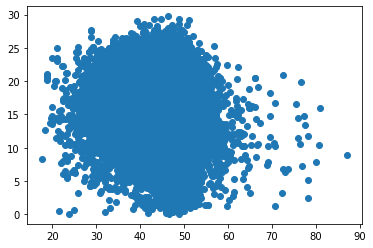

In [113]:
plt.scatter(cp4['tcwv'], cp4['shear'])

In [114]:
obs_shear_tcwv['bins']

array([30.06, 31.11, 32.16, 33.21, 34.26, 35.31, 36.36, 37.41, 38.46,
       39.51, 40.56, 41.61, 42.66, 43.71, 44.76, 45.81, 46.87, 47.92,
       48.97, 50.02, 51.07, 52.12, 53.17, 54.22])

In [115]:
def gauss(data, sigma):
    sigma=sigma                  # standard deviation for Gaussian kernel
    truncate=4.0               # truncate filter at this many sigmas

    U=data       # random array...

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

def hist2d_duo(ax, dat, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r

    cmap = 'Blues'

    X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
    cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
    
    datplot = dat['data'].copy()
    datmid = gauss(datplot[0:-1,0:-1], 0.75)
    datplot[0:-1,0:-1] = datmid
#     plt.figure()
#     plt.pcolormesh(datplot)
    
#     if valid:
#         datplot[dat['valid']<10] = np.nan  # remove values that appear due to smoothing
        

    Zm = ma.masked_where(np.isnan(datplot),datplot)

    mappable = ax.pcolormesh(X, Y, Zm, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
    ax.set_ylabel(dat['ylabel'])
    ax.set_xlabel(dat['xlabel'])
    ax.set_facecolor('xkcd:grey')
    ax.set_title(dat['title'])
    cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
    cbar.set_label(dat['cbarlabel'])

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Text(0, 4, 'd')

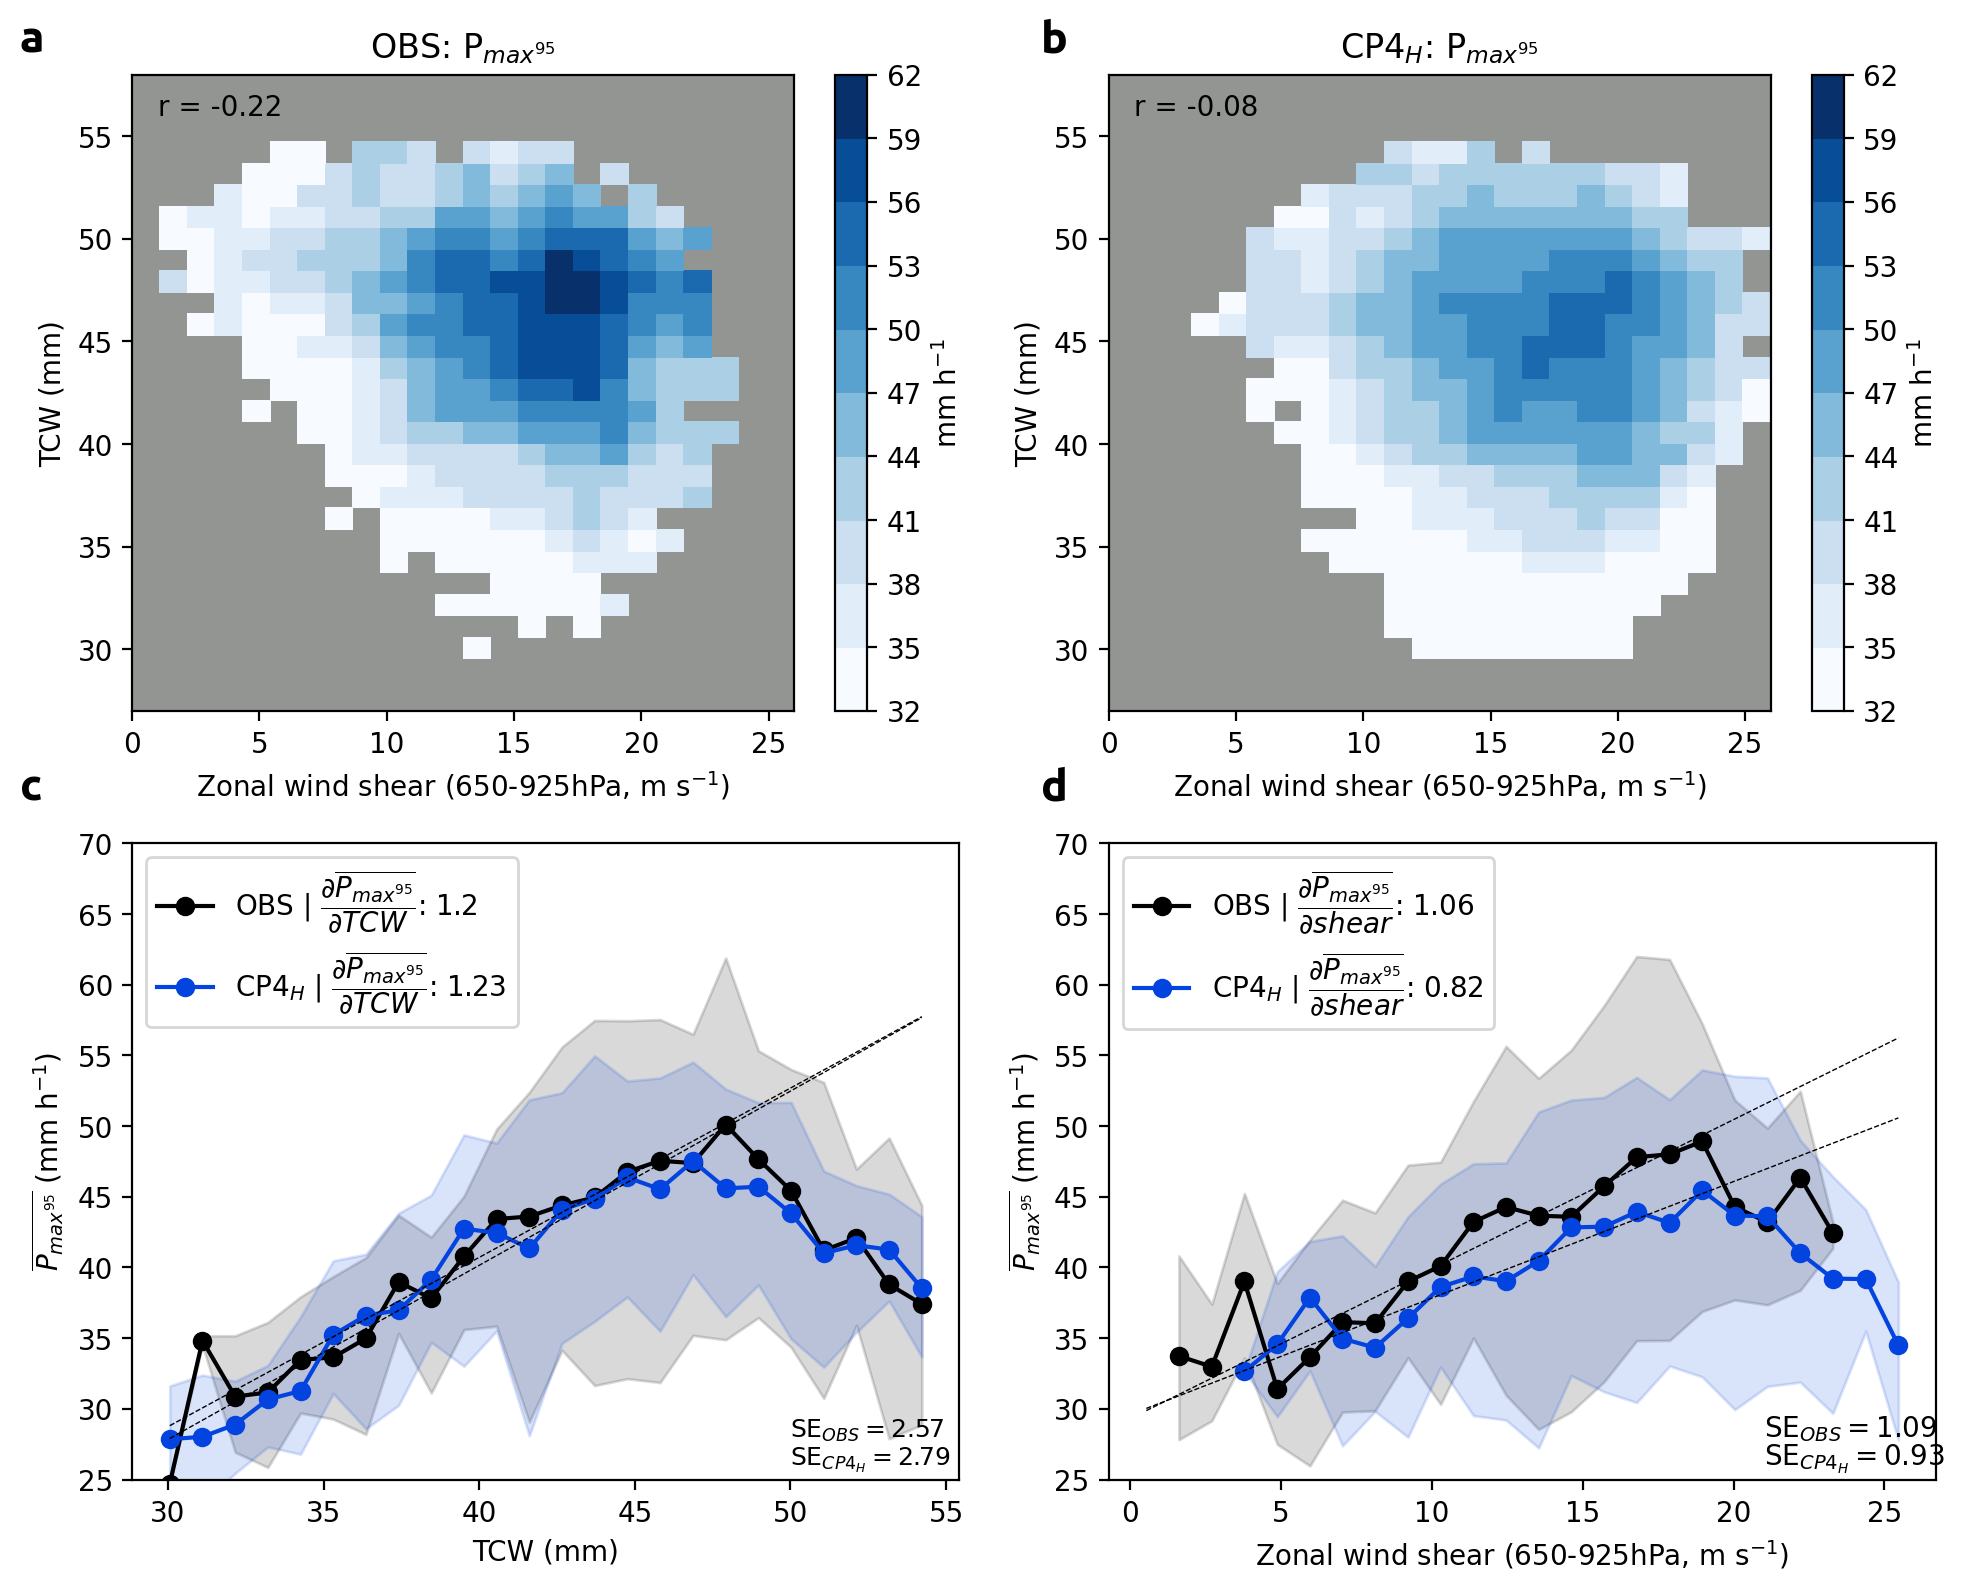

In [116]:
f = plt.figure(figsize=(10,8), dpi=200)
cmap='Blues'
vmins = 32
vmaxs = 62

cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
ax = f.add_subplot(2,2,1)
ax.set_facecolor('xkcd:grey')

dd = gauss(obs_tcwv['prcp'], 0.7)
invalid = obs_tcwv['prcp_val'] < years_needed
dd[invalid] = np.nan

mp = plt.pcolormesh(obs_tcwv['xbins'], obs_tcwv['ybins'], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
#plt.plot(testbins[0][bigpos[1]+1],testbins[1][bigpos[0]+1], 'o', color='grey', ms=1)
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r = '+str(np.round(robs[0],2)), fontsize=10)
plt.title('OBS: P$_{max^{95}}$')

cbar = plt.colorbar(mp, ticks=np.linspace(vmins, vmaxs,11))
cbar.set_label('mm h$^{-1}$')

ax = f.add_subplot(2,2,2)
ax.set_facecolor('xkcd:grey')

dd = gauss(cp4_tcwv['prcp'], 0.7)
invalid = cp4_tcwv['prcp_val'] < years_needed
dd[invalid] = np.nan

mp = plt.pcolormesh(cp4_tcwv['xbins'], cp4_tcwv['ybins'], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
cbar = plt.colorbar(mp, ticks=np.linspace(vmins,vmaxs,11))
cbar.set_label('mm h$^{-1}$')
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r = '+str(np.round(rc4[0],2)), fontsize=10)
plt.title('CP4$_H$: P$_{max^{95}}$')

ax2 = f.add_subplot(223)
tdicobs = obs_shear_tcwv
tdic4 = cp4_shear_tcwv
plt.plot(tdicobs['bins'],tdicobs['pmean'], '-ko', label=r'OBS | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial TCW}$: ' + str(np.round(tdicobs['slope'],2)))
plt.fill_between(tdicobs['bins'],tdicobs['p10'],tdicobs['p90'], color='k', alpha=0.15)
plt.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)
plt.plot(tdic4['bins'],tdic4['pmean'], color='xkcd:blue', marker='o', label='CP4$_H$ | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial TCW}$: ' + str(np.round(tdic4['slope'],2)))

plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']+tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)
# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']-tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)

# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']+tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']-tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('TCW (mm)')
plt.ylabel('$\overline{P_{max^{95}}}$ (mm h$^{-1}$)')


#plt.title('Zonal wind shear')
#plt.ylim(12,31)
#plt.ylim(15,33)
plt.ylim(25,70)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
plt.legend(loc='upper left')
plt.text(50,28, r'SE$_{OBS} = $'+str(np.round(tdicobs['std_est'],2)), fontsize=9)
plt.text(50,26, r'SE$_{CP4_H} = $'+str(np.round(tdic4['std_est'],2)), fontsize=9)




ax3 = f.add_subplot(224)

sdicobs = obs_tcwv_shear
sdic4 = cp4_tcwv_shear

plt.plot(sdicobs['bins'],sdicobs['pmean'], '-ko', label=r'OBS | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdicobs['slope'],2)))
plt.fill_between(sdicobs['bins'],sdicobs['p10'],sdicobs['p90'], color='k', alpha=0.15)
plt.fill_between(sdic4['bins'],sdic4['p10'],sdic4['p90'], color='xkcd:blue', alpha=0.15)

plt.plot(sdic4['bins'],sdic4['pmean'], color='xkcd:blue', marker='o', label=r'CP4$_{H}$ | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdic4['slope'],2)))
plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(sdic4['bins'],sdic4['slope']*sdic4['bins']+sdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

#fdic = {'obs_shear' : sdicobs['slope'], 'cp4_shear' : sdic4['slope']}
# import pickle
# pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_new.p', "wb"))

#plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')

plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('$\overline{P_{max^{95}}}$ (mm h$^{-1}$)')
#plt.title('Total column water vapour')
plt.legend(loc='upper left')
plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(sdicobs['std_est'],2)), fontsize=10)
plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(sdic4['std_est'],2)), fontsize=10)
plt.tight_layout()
plt.ylim(25,70)
ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.yaxis.set_minor_locator(MultipleLocator(5))


text = ['a', 'b', 'c', 'd']
plt.annotate(text[0], xy=(0.01, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.53, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.01, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.53, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)


#plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_NOFUTURE_50Cp90_duo_gauss_hourly2_0.1mm_new.jpg')

In [104]:
obs_shear_tcwv.keys()

dict_keys(['slope', 'intercept', 'rval', 'pmean', 'p90', 'p10', 'bins', 'std_est', 'val'])

Text(0, 4, 'd')

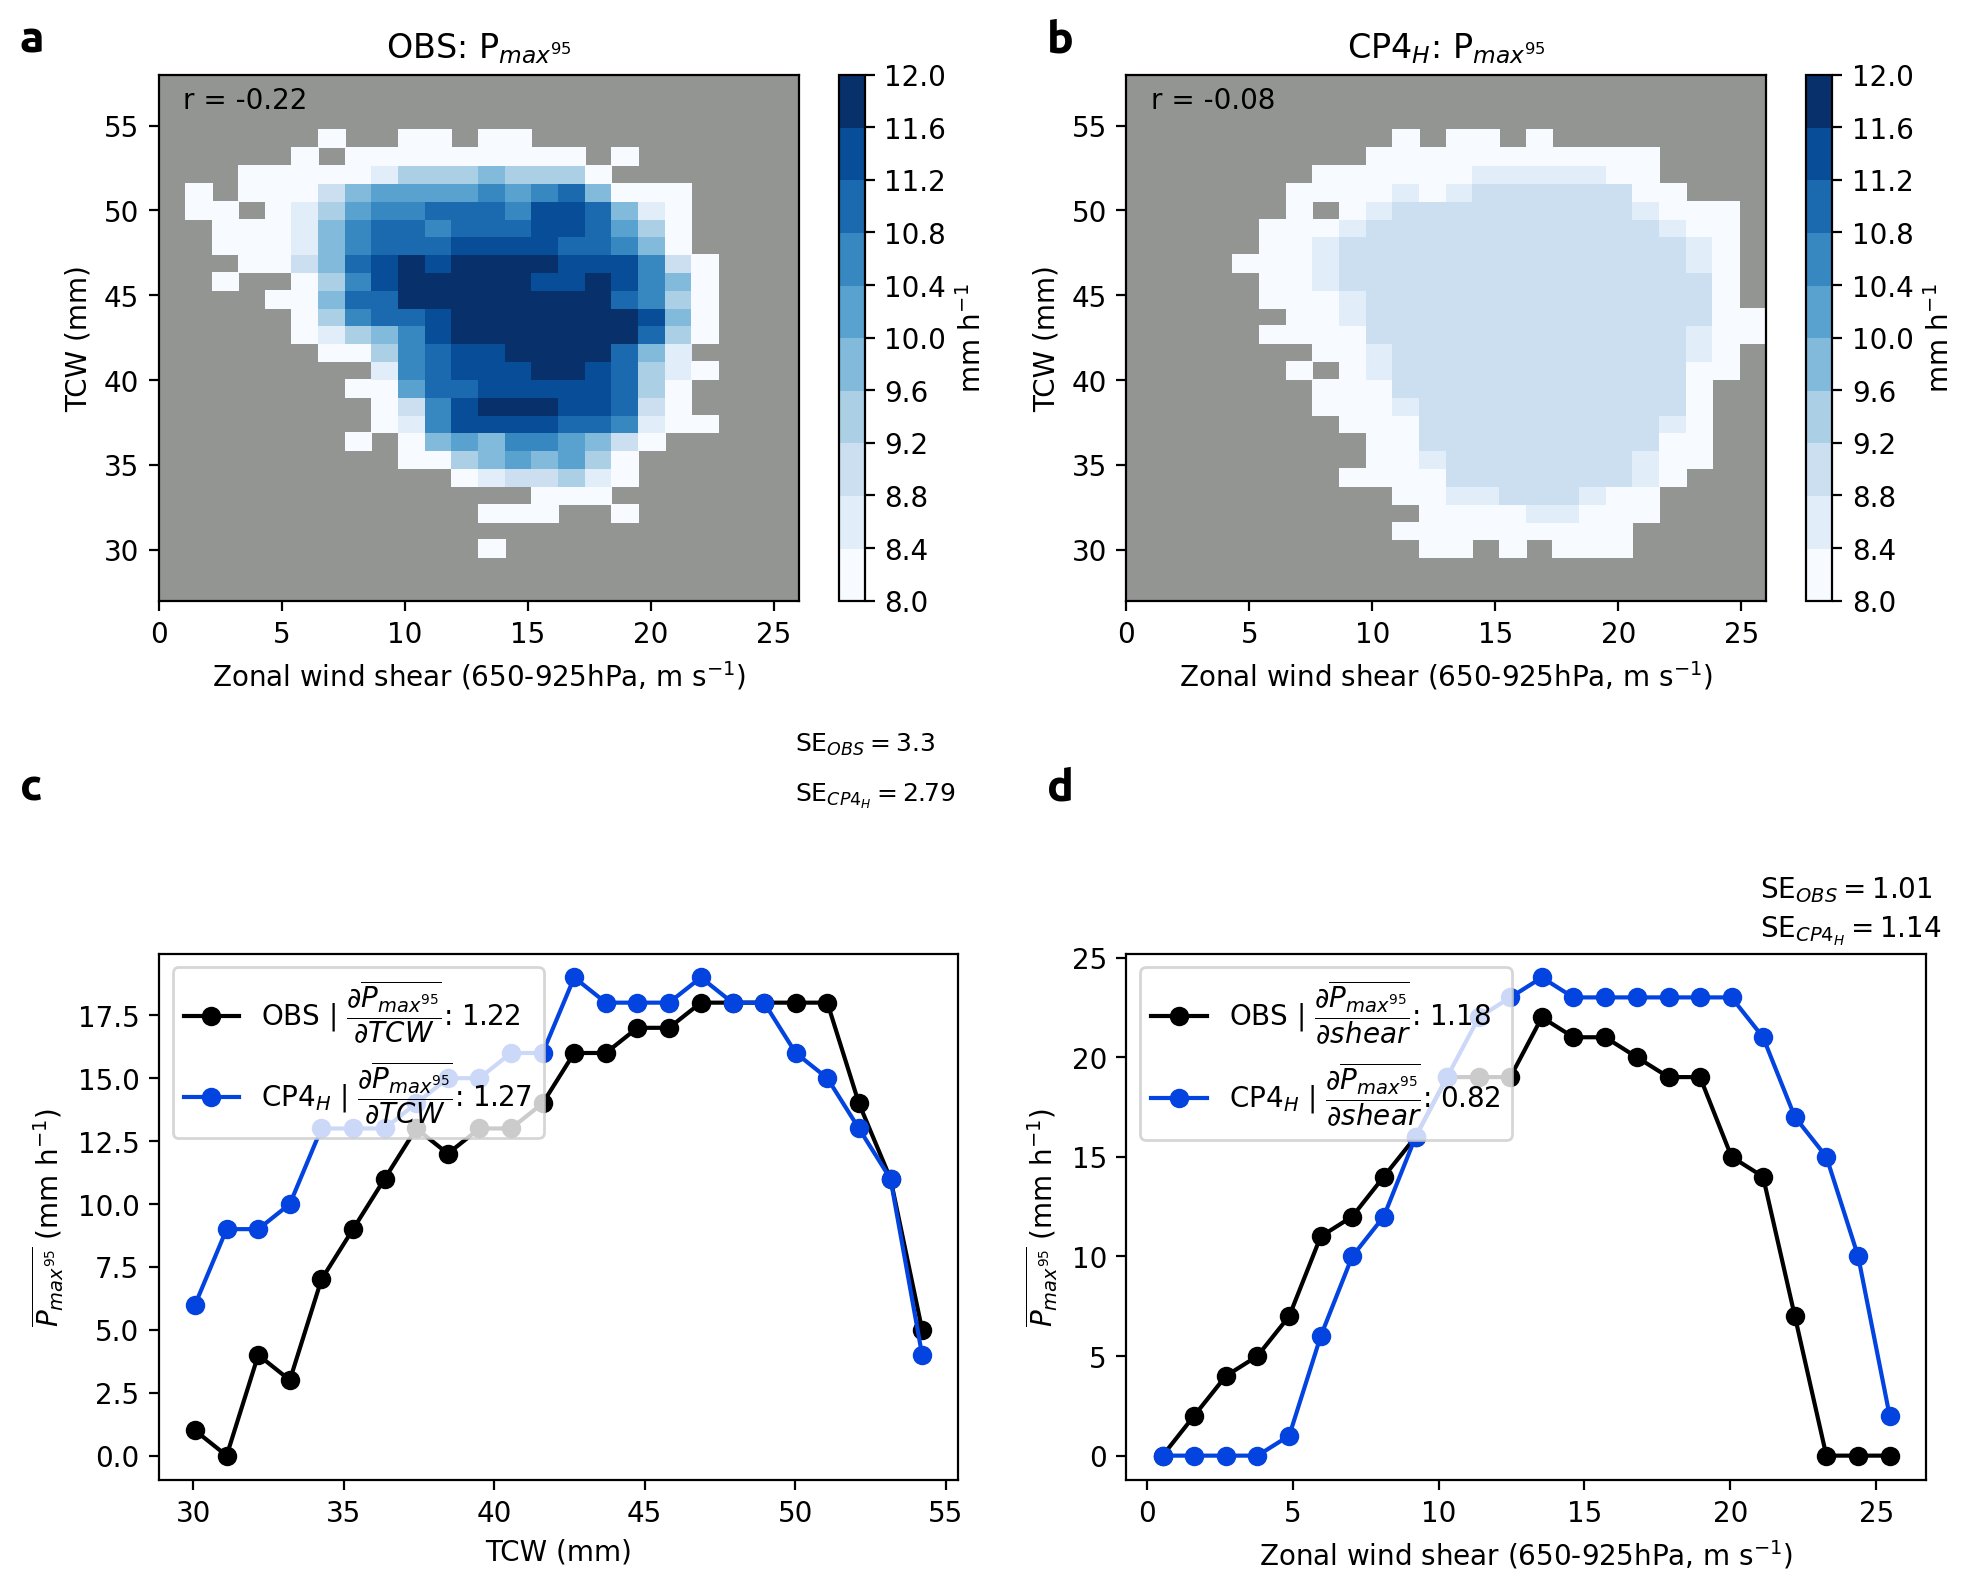

In [105]:
f = plt.figure(figsize=(10,8), dpi=200)
cmap='Blues'
vmins = 8
vmaxs = 12

cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
ax = f.add_subplot(2,2,1)
ax.set_facecolor('xkcd:grey')

dd = gauss(obs_tcwv['prcp_val'], 0.7)
invalid = obs_tcwv['prcp_val'] < years_needed
dd[invalid] = np.nan

mp = plt.pcolormesh(obs_tcwv['xbins'], obs_tcwv['ybins'], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
#plt.plot(testbins[0][bigpos[1]+1],testbins[1][bigpos[0]+1], 'o', color='grey', ms=1)
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r = '+str(np.round(robs[0],2)), fontsize=10)
plt.title('OBS: P$_{max^{95}}$')

cbar = plt.colorbar(mp, ticks=np.linspace(vmins, vmaxs,11))
cbar.set_label('mm h$^{-1}$')

ax = f.add_subplot(2,2,2)
ax.set_facecolor('xkcd:grey')

dd = gauss(cp4_tcwv['prcp_val'], 0.7)
invalid = cp4_tcwv['prcp_val'] < years_needed
dd[invalid] = np.nan

mp = plt.pcolormesh(cp4_tcwv['xbins'], cp4_tcwv['ybins'], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
cbar = plt.colorbar(mp, ticks=np.linspace(vmins,vmaxs,11))
cbar.set_label('mm h$^{-1}$')
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r = '+str(np.round(rc4[0],2)), fontsize=10)
plt.title('CP4$_H$: P$_{max^{95}}$')

ax2 = f.add_subplot(223)
tdicobs = obs_shear_tcwv
tdic4 = cp4_shear_tcwv
plt.plot(tdicobs['bins'],tdicobs['val'], '-ko', label=r'OBS | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial TCW}$: ' + str(np.round(tdicobs['slope'],2)))
# plt.fill_between(tdicobs['bins'],tdicobs['p10'],tdicobs['p90'], color='k', alpha=0.15)
# plt.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)
plt.plot(tdic4['bins'],tdic4['val'], color='xkcd:blue', marker='o', label='CP4$_H$ | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial TCW}$: ' + str(np.round(tdic4['slope'],2)))

# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']+tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)
# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']-tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)

# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']+tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']-tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('TCW (mm)')
plt.ylabel('$\overline{P_{max^{95}}}$ (mm h$^{-1}$)')


#plt.title('Zonal wind shear')
#plt.ylim(12,31)
#plt.ylim(15,33)
#plt.ylim(25,70)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
plt.legend(loc='upper left')
plt.text(50,28, r'SE$_{OBS} = $'+str(np.round(tdicobs['std_est'],2)), fontsize=9)
plt.text(50,26, r'SE$_{CP4_H} = $'+str(np.round(tdic4['std_est'],2)), fontsize=9)




ax3 = f.add_subplot(224)
vmins = 8
vmaxs = 10
sdicobs = obs_tcwv_shear
sdic4 = cp4_tcwv_shear

plt.plot(sdicobs['bins'],sdicobs['val'], '-ko', label=r'OBS | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdicobs['slope'],2)))
# plt.fill_between(sdicobs['bins'],sdicobs['p10'],sdicobs['p90'], color='k', alpha=0.15)
# plt.fill_between(sdic4['bins'],sdic4['p10'],sdic4['p90'], color='xkcd:blue', alpha=0.15)

plt.plot(sdic4['bins'],sdic4['val'], color='xkcd:blue', marker='o', label=r'CP4$_{H}$ | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdic4['slope'],2)))
# plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(sdic4['bins'],sdic4['slope']*sdic4['bins']+sdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

#fdic = {'obs_shear' : sdicobs['slope'], 'cp4_shear' : sdic4['slope']}
# import pickle
# pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_new.p', "wb"))

#plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')

plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('$\overline{P_{max^{95}}}$ (mm h$^{-1}$)')
#plt.title('Total column water vapour')
plt.legend(loc='upper left')
plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(sdicobs['std_est'],2)), fontsize=10)
plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(sdic4['std_est'],2)), fontsize=10)
plt.tight_layout()
#plt.ylim(25,70)
ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.yaxis.set_minor_locator(MultipleLocator(5))


text = ['a', 'b', 'c', 'd']
plt.annotate(text[0], xy=(0.01, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.53, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.01, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.53, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)


#plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_NOFUTURE_50Cp90_duo_gauss_hourly2_0.1mm_new.jpg')